# <center> CLASSIFICAÇÃO DE GRANITOS

In [1]:
#utilitários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Pré processamento
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

#Modelos
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Bibliotecas para implementar redes neurais
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

#Avaliadores
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score, confusion_matrix

#Otimizadores
from sklearn.model_selection import GridSearchCV

#salvar e carregar modelos treinados
import joblib

In [2]:
#funções usadas no notebook

def treino_de_classificadores(classificadores, X_treino, y_treino):
    for classificador in classificadores:
        classificador.fit(X_treino, np.ravel(y_treino))
        y_previsao = cross_val_predict(classificador, X_treino, np.ravel(y_treino), cv = 10)
        precisao = precision_score(y_treino, y_previsao, average = 'macro')
        revocacao = recall_score(y_treino, y_previsao, average = 'macro')
        pontuacao_f1 = f1_score(y_treino, y_previsao, average = 'macro')
        print(classificador.__class__.__name__)
        print(f'precisão:{precisao}, revocação:{revocacao}, F1 score: {pontuacao_f1}')
        
def teste_de_modelos(modelos, X_teste, y_teste):
    for modelo in modelos:
        previsoes_teste = modelo.predict(X_teste)
        print(modelo.__class__.__name__)
        print(classification_report(y_teste, previsoes_teste))
        print('_________________________________________________________________________________________________________')
        
def metricas_score(modelos, X_teste, y_teste):
    metricas_modelo = {}
    for indice, modelo in enumerate(modelos):
        nome = modelo.__class__.__name__
        previsao = modelo.predict(X_teste)
        f1 = f1_score(y_teste, previsao, average='macro')
        precisao = precision_score(y_teste, previsao, average='macro')
        acuracia = accuracy_score(y_teste, previsao)
        metricas_modelo[indice] = nome, f1, acuracia, precisao
        
    return pd.DataFrame.from_dict(metricas_modelo, orient='index', columns=['Modelo', 'F1', 'Acurácia', 'Precisão'])

#métricas para as redes neurais artificiais precisam de uma pequena adaptação devido a previsão multirótulo gerada

def metricas_score_ann(modelos, X_teste, y_teste):
    metricas_modelo = {}
    for indice, modelo in enumerate(modelos):
        nome = modelo.__class__.__name__
        previsao = modelo.predict(X_teste)
        f1 = f1_score(y_teste, previsao.round().argmax(axis=1), average='macro')
        precisao = precision_score(y_teste, previsao.round().argmax(axis=1), average='macro')
        acuracia = accuracy_score(y_teste, previsao.round().argmax(axis=1))
        metricas_modelo[indice] = nome, f1, acuracia, precisao
        
    return pd.DataFrame.from_dict(metricas_modelo, orient='index', columns=['Modelo', 'F1', 'Acurácia', 'Precisão'])

#Função para gerar os pesos das classes para as redes neurais

def pesos_classe(contagem_por_classe, contagem_total):
    
    c = 0
    pesos_classes = {}
    
    for classe in contagem_por_classe:
        peso = contagem_total/(len(contagem_por_classe)*classe)
        pesos_classes[c] = peso
        c += 1
    
    return pesos_classes 

In [3]:
#para rodar o tensorflow apenas na CPU (Minha GPU tá com problemas)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## <center> CARREGANDO OS DADOS

In [4]:
#Carregando o database tratado
database = pd.read_csv('granites_dnn/Granites_Machine_Learning_classification/dataset/granitos_db_att.csv', sep = '\t', index_col = 0)
database.head()

,SiO2,TiO2,Al2O3,FeOt,CaO,MgO,MnO,K2O,Na2O,A/NK,A/CNK,Fe#,K2O/Na2O,Na2O+K2O,Q,An,Ab,Or,Group
0,65.40690,0.827037,17.08490,4.914410,1.813515,1.796028,0.077149,5.131949,2.660096,1.719984,1.291329,0.732353,1.929235,7.792045,24.548928,7.115483,22.508991,30.328349,1- CPG & MPG
1,69.64232,0.708766,14.88713,4.186309,1.436880,1.629346,0.053972,5.018386,2.215911,1.639651,1.273279,0.719834,2.264706,7.234297,32.669551,5.684928,18.750421,29.657224,1- CPG & MPG
2,70.61077,0.570585,15.28393,2.822104,1.204323,1.330627,0.053181,5.597277,2.329983,1.544776,1.264847,0.679578,2.402282,7.927260,31.635693,4.686449,19.715667,33.078304,1- CPG & MPG
3,70.61724,0.477503,15.70859,2.508109,1.311569,0.977942,0.040661,5.280680,2.877528,1.502937,1.223734,0.719470,1.835145,8.158208,29.973384,5.199155,24.348840,31.207307,1- CPG & MPG
4,70.70878,0.532211,15.28031,2.535746,1.235924,1.207156,0.060856,5.569955,2.642243,1.472364,1.210301,0.677481,2.108040,8.212198,30.221927,4.649750,22.357924,32.916839,1- CPG & MPG


### <center> PRE PROCESSAMENTO

In [5]:
#verificando dados ausentes no database

database.isna().sum()

SiO2        0
TiO2        0
Al2O3       0
FeOt        0
CaO         0
MgO         0
MnO         0
K2O         0
Na2O        0
A/NK        0
A/CNK       0
Fe#         0
K2O/Na2O    0
Na2O+K2O    0
Q           0
An          0
Ab          0
Or          0
Group       0
dtype: int64

In [6]:
#Removendo colunas com dados ausentes

database = database.dropna(subset=['MnO', 'TiO2','FeOt', 'MgO', 'Na2O', 'CaO', 'Al2O3'])


#Separando variáveis preditoras e variável alvo

database_preditores = database[['SiO2', 'TiO2', 'Al2O3','FeOt', 'MnO', 'MgO', 'CaO', 
                                'K2O', 'Na2O']]

database_alvo = database[['Group']]

In [7]:
#Preparando a separação dos dados de treino e teste

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

#Realizando um amostragem estratificada

for train_index, test_index in split.split(database_preditores, database_alvo):
    X_treino, X_teste = database_preditores.iloc[train_index], database_preditores.iloc[test_index]
    y_treino, y_teste = database_alvo.iloc[train_index], database_alvo.iloc[test_index]

In [8]:
X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape

((2548, 9), (638, 9), (2548, 1), (638, 1))

In [9]:
#Realizando balanceamento de classes com over-sampling (Sobreamostragem) utilizando SMOTE
#SMOTE -> Synthetic Minority Over-sampling Technique

SMOTE_ = SMOTE(random_state=42)
X_treino_smt, y_treino_smt = SMOTE_.fit_resample(X_treino, y_treino)

In [10]:
#Escalonando as variáveis numéricas

atributos_numericos = ['SiO2', 'TiO2', 'Al2O3','FeOt', 'MnO', 'MgO', 'CaO', 
                                'K2O', 'Na2O']

tratamento_pipeline = ColumnTransformer([
    ("atributos_numéricos", StandardScaler(), atributos_numericos),
])

X_treino_smt =  pd.DataFrame(tratamento_pipeline.fit_transform(X_treino_smt))
X_treino_std = pd.DataFrame(tratamento_pipeline.fit_transform(X_treino))

# <center> TESTANDO OS MELHORES MODELOS

In [11]:
#Melhores modelos pós grid search (omiti o grid search aqui devido ao grande tempo de execução)

best_rnd_clf = RandomForestClassifier(bootstrap=False,max_features=3, criterion='gini', n_estimators=700)
best_rnd_clf_wgt = RandomForestClassifier(bootstrap=False,max_features=3, criterion='gini', n_estimators=700, class_weight='balanced_subsample')
best_svm_clf = SVC(kernel='rbf' ,C=300, gamma=1)
best_svm_clf_wgt = SVC(kernel='rbf' ,C=300, gamma=1, class_weight='balanced')
best_ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10) ,algorithm='SAMME', n_estimators=100, learning_rate=0.75)
best_ada_clf_wgt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, class_weight='balanced') ,algorithm='SAMME', n_estimators=100, learning_rate=0.75)


modelos = [best_rnd_clf, best_svm_clf, best_ada_clf,] #best_gb_clf]
modelos_wgt = [best_rnd_clf_wgt, best_svm_clf_wgt, best_ada_clf_wgt ]

In [12]:
#Treinando classificadores com over sampling

treino_de_classificadores(modelos, X_treino_smt, y_treino_smt)

RandomForestClassifier
precisão:0.9372064296925714, revocação:0.9375857338820301, F1 score: 0.9372846770425557
SVC
precisão:0.9403448638696319, revocação:0.9396433470507545, F1 score: 0.9397359259824634
AdaBoostClassifier
precisão:0.9425713030302555, revocação:0.9428440786465478, F1 score: 0.9426531052047403


In [13]:
#Treinando classificadores com pesos para as classes

treino_de_classificadores(modelos_wgt, X_treino_std, y_treino)

RandomForestClassifier
precisão:0.8847178205986616, revocação:0.8772612985613689, F1 score: 0.880779835925329
SVC
precisão:0.8655820509613843, revocação:0.8392117507459922, F1 score: 0.8506369593393223
AdaBoostClassifier
precisão:0.8951836928788142, revocação:0.8879904561073655, F1 score: 0.8913434100225032


In [14]:
#Estabelecendo a estrutura das redes neurais
rede_neural = keras.models.Sequential()
rede_neural.add(keras.layers.Dense(units=100, activation="relu"))
rede_neural.add(keras.layers.Dense(units=100, activation="relu"))
rede_neural.add(keras.layers.Dense(units=100, activation="relu"))
rede_neural.add(keras.layers.Dense(6, activation="softmax"))

In [15]:
rede_neural_smt = keras.models.Sequential()
rede_neural_smt.add(keras.layers.Dense(units=100, activation="relu"))
rede_neural_smt.add(keras.layers.Dense(units=100, activation="relu"))
rede_neural_smt.add(keras.layers.Dense(units=100, activation="relu"))
rede_neural_smt.add(keras.layers.Dense(6, activation="softmax"))

In [16]:
#Compilando as redes e modificando o padrão de aprendizado do otimizador


otimizador = keras.optimizers.SGD(learning_rate = 0.05)

rede_neural.compile(loss="sparse_categorical_crossentropy",
                    optimizer=otimizador,
                    metrics=["accuracy"])

rede_neural_smt.compile(loss="sparse_categorical_crossentropy",
                    optimizer=otimizador,
                    metrics=["accuracy"])

In [17]:
#Calculando pesos balanceados para as classes, para utilizar na rede neural

contagem_por_classe = y_treino.value_counts().sort_index().to_list()
contagem_total = y_treino.value_counts().sum()
pesos = pesos_classe(contagem_por_classe, contagem_total)

In [18]:
pesos

{0: 0.8376068376068376,
 1: 1.9480122324159022,
 2: 2.2350877192982455,
 3: 0.582533150434385,
 4: 0.7693236714975845,
 5: 1.206439393939394}

In [19]:
encoder = LabelEncoder()
y_treino_one_hot = encoder.fit_transform(np.ravel(y_treino))
y_treino_one_hot_smt = encoder.fit_transform(np.ravel(y_treino_smt))

In [20]:
modelo_com_pesos=rede_neural.fit(X_treino_std, y_treino_one_hot, epochs=1000, class_weight=pesos, verbose=0, 
                                   callbacks=[keras.callbacks.EarlyStopping(patience=10,  monitor="accuracy")])

In [21]:
modelo_com_oversampling=rede_neural_smt.fit(X_treino_smt, y_treino_one_hot_smt, epochs=1000, verbose=0, callbacks=[keras.callbacks.EarlyStopping(patience=10,  monitor="accuracy")])

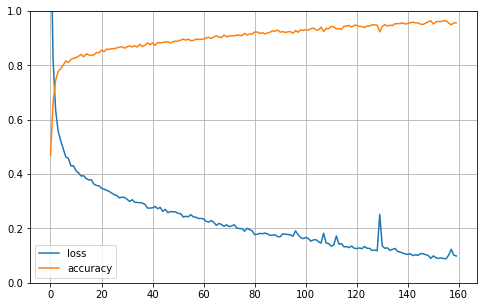

In [22]:
pd.DataFrame(modelo_com_pesos.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

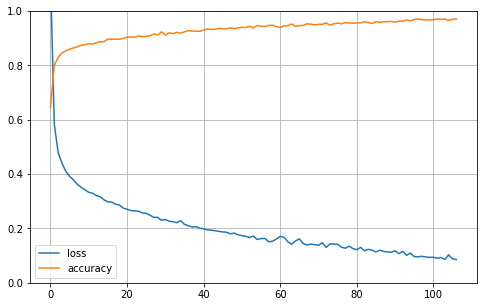

In [23]:
pd.DataFrame(modelo_com_oversampling.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [24]:
#TRANSFORMANDO OS DADOS DE TESTE
escaler = StandardScaler() 

X_teste_std = escaler.fit_transform(X_teste)
y_teste_ann = encoder.fit_transform(np.ravel(y_teste))


In [25]:
metricas_modelos_com_peso = metricas_score(modelos_wgt, X_teste_std, y_teste)
metricas_modelos_com_smote = metricas_score(modelos, X_teste_std, y_teste)

In [26]:
modelos_ann = [rede_neural, rede_neural_smt]
metricas_modelos_ann = metricas_score_ann(modelos_ann, X_teste_std, y_teste_ann)

20/20 [==============================] - 0s 1ms/step


In [28]:
scores_modelos = pd.concat([metricas_modelos_com_peso, metricas_modelos_com_smote, metricas_modelos_ann], axis=0).reset_index()

In [29]:
scores_modelos = scores_modelos.drop(columns=['index'])
scores_modelos['Grupo'] = ['weight', 'weight', 'weight', 'smote', 'smote', 'smote', 'weight', 'smote']

In [30]:
scores_modelos

,Modelo,F1,Acurácia,Precisão,Grupo
0,RandomForestClassifier,0.880838,0.866771,0.879073,weight
1,SVC,0.854563,0.846395,0.871532,weight
2,AdaBoostClassifier,0.888642,0.876176,0.894211,weight
3,RandomForestClassifier,0.815983,0.821317,0.803133,smote
4,SVC,0.826441,0.822884,0.827127,smote
5,AdaBoostClassifier,0.818853,0.826019,0.806698,smote
6,Sequential,0.870649,0.865204,0.868505,weight
7,Sequential,0.809230,0.833856,0.816853,smote


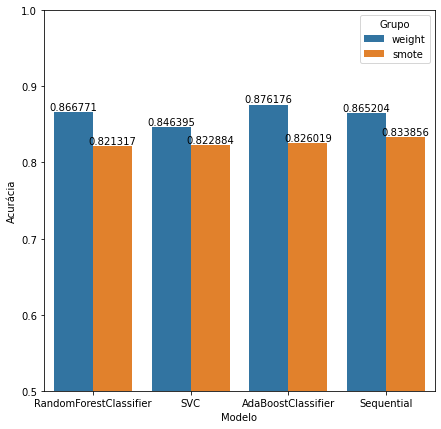

In [31]:
plt.figure(figsize = (7, 7))
plt.ylim(0.5, 1)
ax = sns.barplot(x=scores_modelos['Modelo'], y=scores_modelos['Acurácia'], hue=scores_modelos['Grupo'], data=scores_modelos)
for container in ax.containers:
    ax.bar_label(container)
#plt.savefig('Scores_modelos.pdf', dpi=600, format='pdf')